# Weddell Sea WES SDM

### Loading the required libraries and other dependencies

In [30]:
## Clear memory
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2569587,137.3,3886542,207.6,3886542,207.6
Vcells,2728853,20.9,26106160,199.2,55134522,420.7


In [31]:
libs<-c("viridis","ggplot2","plyr","dplyr","fmsb","caret","randomForest","ranger","gbm","nlme","sp","raster","sf","caTools","maptools","spocc","ENMeval","rJava","dismo","parallel","ROCR","rgdal")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ubuntu/Workspace/ContinentalWESEestimates/"


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

CRS arguments:
 +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0 

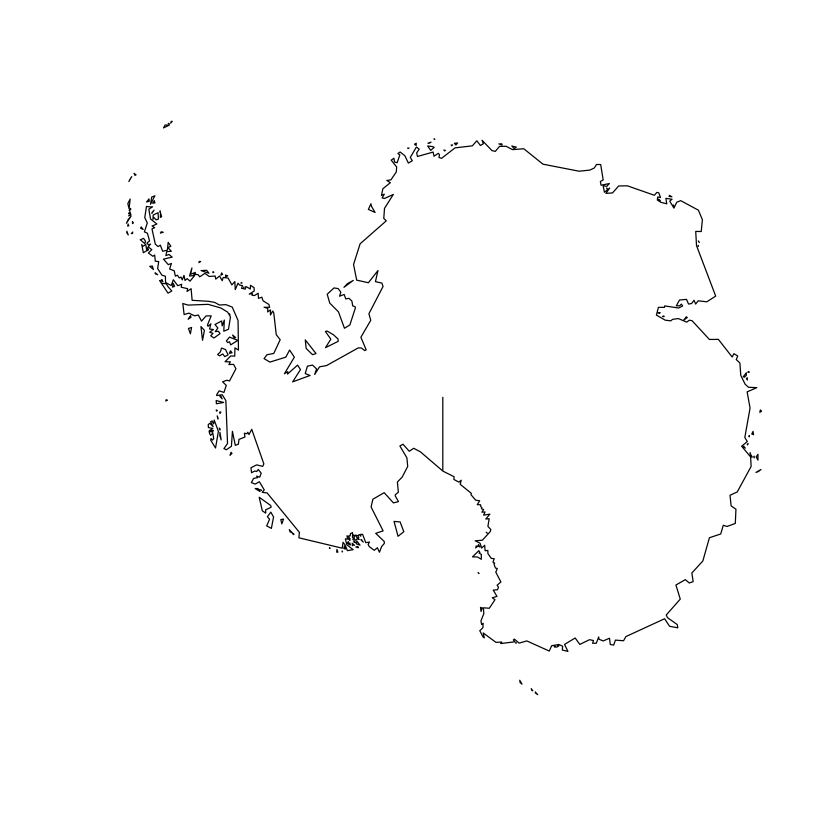

In [58]:
#Create basemap for Antarctica - will need later for some plotting and error checking
data(wrld_simpl)
ant <-  wrld_simpl[wrld_simpl$NAME == "Antarctica", ]
crs(ant)
prj <- "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"
ant <- sp::spTransform(ant, CRSobj = prj)
plot(ant)


### We will now do the following steps:
1. Recreate raster layers of the predictor variables we will use to build models. 
We need them to 1) calculate variance inflation factors
2) Predict over

In [ ]:
rasterdir <- paste0(pathToLocalGit,"data/WESPresenceEnviroLayers/")

#I need a raster to act as the mask or grid. I butchered this, but it works. First, I use the coordinates I used for the
#CES paper to create an empty raster, but then I need to project to polar stereographic, then I use slope to 
#get outline of Antarctic Continent involved - to act as land mask. Then finally you have your final mask.
# There is a shorter easier way, I was just lazy

## Make an exmpty raster based on cES coords
lims <- c(-85, 0, -90, -50)
grd_mask <- raster(extent(lims), resolution = c(0.1, 0.1))
projection(grd_mask) <- "+proj=longlat +datum=WGS84"
values(grd_mask) <- 1

#Reproject to Leo's polar stereographic projection.
prj <- "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"
grd_mask_stere <- projectRaster(from = grd_mask,crs = prj)
plot(grd_mask_stere)

#Get Leo's slope layer with 5km resolution and Antarctic continent already mapped out.
slope <- raster("/home/ubuntu/fastIce/FastIceCovars/data/layers/slope_deg_avg5km.tif")
plot(slope)

#But now we turn all the values from slope into 1's. But we want to keep the NA's there because they act as landmask.
msk <- crop(slope,extent(grd_mask_stere))
msk[!(is.na(msk))] <- 1
plot(msk)
names(msk) <- "mask"

#Delete all the other crap I'm not going to use
rm(grd_mask, grd_mask_stere,lims,slope)

# Get only response and predictors that we'll work with and creater new df (with shorter name)
alldat <- wes #presence/absence and predictors
coords <- weddellSeaData[,c(18:19)] #coordinates
names(coords) <- c("lon","lat")

stk <- raster::stack()

for (i in 1:ncol(alldat)){
  foo <- cbind(coords,alldat[,i])
  r <- rasterFromXYZ(foo, res=c(5000,5000), crs=prj)
  r <- crop(r,extent(msk))
  names(r) <- colnames(alldat)[i]
  plot(r,main = names(r))
  stk <- stack(stk,r)
  writeRaster(r, paste0(rasterdir, names(r),".tif"), overwrite = TRUE)
  print(i)
}

rm(i,r,foo,alldat)
nlayers(stk)
names(stk)


# Center and scale rasters ----
foo <- scale(stk, center = TRUE, scale = TRUE)
par(mfrow=c(1,2))
plot(stk[[2]])
plot(foo[[2]])
par(mfrow=c(1,1))

foo[[1]] #Check that first layer is presence
nlayers(foo)
foo <- dropLayer(foo,1) #Drop presence layer
nlayers(foo)

for (i in 1:nlayers(foo)){
  writeRaster(foo[[i]], paste0(rasterdir,"/Enviro_CenterScaled/",names(foo[[i]]),".tif"), overwrite = TRUE)
}

rm(foo,i)



### Variance Inflation Factor Calculations
#### Here you will take the raster stack of all the environmental variables you just created, center and scale them, and calculate VIF values and drop values with a VIF > 10

In [37]:
### Now we run the VIF 
# select covariates to use in the models based on variance inflation
# If variable A is excluded because of VIF_A > thresh, it means that a regression of all other covariates vs A explains 90% or more of all the variance found in A
# This function returns the names of the variables to keep for your model. These are the most informative variables.

#Getting Environmental Variables for occupancy

#Read in the list of enviro rasters -----
#Please note that for VIF you need to work on the original rasters from the entire area that you plan to predict over.
rasterdir <- paste0(pathToLocalGit,"data/WESPresenceEnviroLayers/")
rastlist <- list.files(path = paste0(rasterdir,"/Enviro_CenterScaled/"), pattern='.tif$', all.files=TRUE, full.names=TRUE)
length(rastlist)
r <- stack(rastlist)
names(r)

#Convert to data frame for vif ---
ras <- as.data.frame(r, na.rm = TRUE)
names(ras)
ras$presence <- NULL #Response var, not include here.
head(ras)
summary(ras)

#VIF Function ----
vif_func<-function(df,thresh=10){
  #get initial vif value for all comparisons of variables
  vif_init<-NULL
  var_names <- names(df)
  for(val in var_names){
    
    regressors <- var_names[-which(var_names == val)]
    form <- paste(regressors, collapse = '+')
    form_in <- formula(paste(val, '~', form))
    vif_init<-rbind(vif_init, c(val, VIF(lm(form_in, data = df))))
  }
  vif_max<-max(as.numeric(vif_init[,2]), na.rm = TRUE)
  if(vif_max < thresh){
  return(var_names)
  }
  else{
      in_dat<-df
  #backwards selection of explanatory variables, stops when all VIF values are below 'thresh'
  while(vif_max >= thresh){
  vif_vals<-NULL
  var_names <- names(in_dat)
  for(val in var_names){
        regressors <- var_names[-which(var_names == val)]
        form <- paste(regressors, collapse = '+')
        form_in <- formula(paste(val, '~', form))
        vif_add<-VIF(lm(form_in, data = in_dat))
        vif_vals<-rbind(vif_vals,c(val,vif_add))
        }
      
      max_row<-which(vif_vals[,2] == max(as.numeric(vif_vals[,2]), na.rm = TRUE))[1]
      vif_max<-as.numeric(vif_vals[max_row,2])
      
      if(vif_max<thresh) break
        in_dat<-in_dat[,!names(in_dat) %in% vif_vals[max_row,1]]
          }
    return(names(in_dat))
  }
}

vif <- vif_func(ras)
vif #This is all the covariates we retain for modelling...

names(ras)[!(names(ras) %in% vif)]
rm(rastlist,ras,r,vif_func)

#saveRDS(vif,paste0(getwd(),"/0. Data/VIFKeeps.RDS"))   


[1] 19

[1] "ADPEabund"               "ADPEdist"               
 [3] "cont300dist"             "cont800dist"            
 [5] "DecemberIcePresence"     "distNearestIceEdge"     
 [7] "distToShore"             "EMPEabund"              
 [9] "EMPEdist"                "fastIceRatio"           
[11] "fastIceWidth"            "glacierdist"            
[13] "InTrough"                "meanbathy"              
[15] "meanslope"               "Persistence2Years"      
[17] "Persistence3Years"       "PredictabilityDec5Years"
[19] "PredictabilityOct5Years"

[1] "ADPEabund"               "ADPEdist"               
 [3] "cont300dist"             "cont800dist"            
 [5] "DecemberIcePresence"     "distNearestIceEdge"     
 [7] "distToShore"             "EMPEabund"              
 [9] "EMPEdist"                "fastIceRatio"           
[11] "fastIceWidth"            "glacierdist"            
[13] "InTrough"                "meanbathy"              
[15] "meanslope"               "Persistence2Years"      
[17] "Persistence3Years"       "PredictabilityDec5Years"
[19] "PredictabilityOct5Years"

,ADPEabund,ADPEdist,cont300dist,cont800dist,DecemberIcePresence,distNearestIceEdge,distToShore,EMPEabund,EMPEdist,fastIceRatio,fastIceWidth,glacierdist,InTrough,meanbathy,meanslope,Persistence2Years,Persistence3Years,PredictabilityDec5Years,PredictabilityOct5Years
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
417,-0.1809557,1.254519,0.3104145,0.6312245,-1.9786887,-1.0555710,0.9092260,0.4246147,-0.26355541,-1.9846840,-0.6643016,1.176480,-0.450289,0.1204849,-0.4242119,-1.150327,-0.6741129,1.2296128,-0.6641171
833,-0.1809557,1.246465,0.3514363,0.5964308,-1.9786887,-0.9879506,2.1400230,0.2894751,-0.07303555,-1.9019628,-0.1142235,1.253886,-0.450289,0.3347907,-0.3792666,-1.150327,-0.6741129,-0.8366746,-0.6641171
834,-0.1809557,1.253150,0.3514363,0.5964308,0.5051112,-0.8117162,1.6109256,0.3442978,-0.15353452,-1.4679757,-0.1518634,1.209188,-0.450289,0.2362771,-0.4883482,-1.150327,-0.6741129,1.2296128,-0.6641171
835,-0.1809557,1.259846,0.3514363,0.5964308,0.5051112,-0.7329434,0.7942367,0.4018919,-0.23334658,-1.0902296,-0.3971221,1.164544,-0.450289,0.1057705,-0.4103886,-1.150327,-0.6741129,1.2296128,-0.6641171
1251,-0.1809557,1.251837,0.3934034,0.5618368,0.5051112,-0.9472820,1.4470812,0.2689726,-0.04174354,-1.7339594,-0.3476630,1.243230,-0.450289,0.3630540,-0.4064777,-1.150327,-0.6741129,-0.8366746,-0.6641171
1252,-0.1809557,1.258508,0.3934034,0.5618368,0.5051112,-0.6406618,1.0141212,0.3214010,-0.12046585,-0.9966877,-0.2211776,1.198328,-0.450289,0.2485439,-0.3872844,-1.150327,-0.6741129,1.2296128,-0.6641171


   ADPEabund         ADPEdist         cont300dist       cont800dist      
 Min.   :-0.181   Min.   :-1.32858   Min.   :-1.0637   Min.   :-1.68392  
 1st Qu.:-0.181   1st Qu.:-1.04108   1st Qu.:-0.6752   1st Qu.:-0.73901  
 Median :-0.181   Median : 0.09802   Median :-0.2728   Median :-0.02143  
 Mean   : 0.000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.:-0.181   3rd Qu.: 1.04346   3rd Qu.: 0.3654   3rd Qu.: 0.70377  
 Max.   :10.537   Max.   : 1.47604   Max.   : 4.8208   Max.   : 5.24859  
 DecemberIcePresence distNearestIceEdge  distToShore        EMPEabund      
 Min.   :-1.9787     Min.   :-1.1077    Min.   :-1.3182   Min.   :-0.6996  
 1st Qu.: 0.5051     1st Qu.:-0.7665    1st Qu.:-0.8664   1st Qu.:-0.5604  
 Median : 0.5051     Median :-0.3084    Median :-0.2295   Median :-0.2755  
 Mean   : 0.0000     Mean   : 0.0000    Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.5051     3rd Qu.: 0.4613    3rd Qu.: 0.7469   3rd Qu.: 0.1677  
 Max.   : 0.5051     Max. 

[1] "ADPEabund"               "ADPEdist"               
 [3] "cont300dist"             "cont800dist"            
 [5] "DecemberIcePresence"     "distNearestIceEdge"     
 [7] "distToShore"             "EMPEabund"              
 [9] "EMPEdist"                "fastIceRatio"           
[11] "glacierdist"             "InTrough"               
[13] "meanbathy"               "meanslope"              
[15] "Persistence2Years"       "PredictabilityDec5Years"
[17] "PredictabilityOct5Years"

[1] "fastIceWidth"      "Persistence3Years"

### Loading the data
You can get an updated version of the data, as we add more covariates, from the notebook FitRegressionModels_ofSealAbundancePresence. Just add a cell below the point where the final, attributed dataset is created, and then run the function:
weddellSeaData<-getWeddellSeaData(wesedf)
In the example above, wesedf is the final attributed data.frame for the continental analyses. The result is the subset for the Weddell Sea. Just save it to the "data" folder:
save(weddellSeaData,file=paste0(pathToLocalGit,"data/weddellSeaData.RData"))

In [28]:
names(weddellSeaData)

[1] "gridCellId"              "meanslope"              
 [3] "meanbathy"               "glacierdist"            
 [5] "distToShore"             "cont300dist"            
 [7] "cont800dist"             "DecemberIcePresence"    
 [9] "Persistence2Years"       "PredictabilityDec5Years"
[11] "distNearestIceEdge"      "fastIceWidth"           
[13] "fastIcePresent"          "ADPEname"               
[15] "ADPEdist"                "EMPEname"               
[17] "EMPEdist"                "coords.x1"              
[19] "coords.x2"               "abundance"              
[21] "Persistence3Years"       "PredictabilityOct5Years"
[23] "fastIceRatio"            "ADPEabund"              
[25] "EMPEabund"               "scaledmeanslope"        
[27] "logmeanbathy"            "logglacierdist"         
[29] "logdistToShore"          "logcont300dist"         
[31] "logcont800dist"          "logdistNearestIceEdge"  
[33] "logfastIceWidth"         "logempedist"            
[35] "logadpedist"             "logADPEabund"           
[37] "logEMPEabund"            "Region"                 
[39] "Canyon_ID"               "InCanyon"               
[41] "canyonLength"            "canyonWidth"            
[43] "canyonMeanDepth"         "gtID"                   
[45] "InTrough"                "troughArea"             
[47] "presence"

In [47]:
load(paste0(pathToLocalGit,"/data/weddellSeaData.RData"))
#head(weddellSeaData)
names(weddellSeaData)
#We don't need all these columns and variables
# My criteria for selecting variables were where there are no NA's in the vars, where there were values across all
# factor levels and I excluded all log transformed variables
# Get only response and predictors that we'll work with and creater new df (with shorter name)
wes <- weddellSeaData[,c(47,18:19,2:12,15,17,21:25,45)]
names(wes)
#Rename the coordinates. Yes I know they are not really lon and lat, but the names make it easier for me to keep track of
names(wes)[names(wes) == "coords.x1"] <- "lon"
names(wes)[names(wes) == "coords.x2"] <- "lat"
#summary(wes) #This was to check for NAs. The Canyon varialbes mostly (>1500 of 1844 obs) had NA's so this would have left us with few modelling points. And I don't want to do some imputation - rather just drop the vars.

# VIF ----
# These variables will further be reduced in bottom code based on VIF - not doing now because prediction maps not done

#vif <- readRDS(paste0(pathToLocalGit,"/data/VIFKeeps.RDS"))
# I saved the variables to keep after I ran VIF in an .RDS file, but I use a newer version of R
# and it doesn't want to load here. So I use the names like this.
# # But this should be loaded from previous step
vif <- c("ADPEabund","ADPEdist", "cont300dist","cont800dist","DecemberIcePresence",
         "distNearestIceEdge","distToShore","EMPEabund","EMPEdist","fastIceRatio",
         "glacierdist","InTrough","meanbathy","meanslope","Persistence2Years",
         "PredictabilityDec5Years","PredictabilityOct5Years")

#Get rid of the environmental variables in dataset that was dropped by VIF
(keeps <- c("presence","lon", "lat",vif))
wes2 <- wes[ ,keeps, drop = FALSE]
#nmes(wes2)
bkp <- wes #create backup because I always make tons of mistakes
wes <- wes2
#ames(wes)

names(wes)[!(names(wes) %in% vif)]
rm(keeps,wes2)

#Center and Scale -----
#Center and scale data now. Get it out of the way
#But can't center and scale binary vars, so get them out of data first
 binaryvars <- c("DecemberIcePresence","InTrough")
 (keeps <- c("presence","lon","lat",binaryvars))
 not_scale <- wes[ ,keeps, drop = FALSE]
 to_scale <- wes[,!(names(wes) %in% keeps)]
#  names(not_scale)
#  names(to_scale)  
 foo <- as.data.frame(scale(to_scale, center = TRUE, scale = TRUE))
 wes <- data.frame(cbind(foo,not_scale))
#  head(wes)
#  names(wes)
 wes <- wes[,c(16:18,1:15,19:20)]
#  head(wes)
#  ncol(wes)
 rm(foo)
names(wes)




[1] "gridCellId"              "meanslope"              
 [3] "meanbathy"               "glacierdist"            
 [5] "distToShore"             "cont300dist"            
 [7] "cont800dist"             "DecemberIcePresence"    
 [9] "Persistence2Years"       "PredictabilityDec5Years"
[11] "distNearestIceEdge"      "fastIceWidth"           
[13] "fastIcePresent"          "ADPEname"               
[15] "ADPEdist"                "EMPEname"               
[17] "EMPEdist"                "coords.x1"              
[19] "coords.x2"               "abundance"              
[21] "Persistence3Years"       "PredictabilityOct5Years"
[23] "fastIceRatio"            "ADPEabund"              
[25] "EMPEabund"               "scaledmeanslope"        
[27] "logmeanbathy"            "logglacierdist"         
[29] "logdistToShore"          "logcont300dist"         
[31] "logcont800dist"          "logdistNearestIceEdge"  
[33] "logfastIceWidth"         "logempedist"            
[35] "logadpedist"             "logADPEabund"           
[37] "logEMPEabund"            "Region"                 
[39] "Canyon_ID"               "InCanyon"               
[41] "canyonLength"            "canyonWidth"            
[43] "canyonMeanDepth"         "gtID"                   
[45] "InTrough"                "troughArea"             
[47] "presence"

[1] "presence"                "coords.x1"              
 [3] "coords.x2"               "meanslope"              
 [5] "meanbathy"               "glacierdist"            
 [7] "distToShore"             "cont300dist"            
 [9] "cont800dist"             "DecemberIcePresence"    
[11] "Persistence2Years"       "PredictabilityDec5Years"
[13] "distNearestIceEdge"      "fastIceWidth"           
[15] "ADPEdist"                "EMPEdist"               
[17] "Persistence3Years"       "PredictabilityOct5Years"
[19] "fastIceRatio"            "ADPEabund"              
[21] "EMPEabund"               "InTrough"

[1] "presence"                "lon"                    
 [3] "lat"                     "ADPEabund"              
 [5] "ADPEdist"                "cont300dist"            
 [7] "cont800dist"             "DecemberIcePresence"    
 [9] "distNearestIceEdge"      "distToShore"            
[11] "EMPEabund"               "EMPEdist"               
[13] "fastIceRatio"            "glacierdist"            
[15] "InTrough"                "meanbathy"              
[17] "meanslope"               "Persistence2Years"      
[19] "PredictabilityDec5Years" "PredictabilityOct5Years"

[1] "presence" "lon"      "lat"

[1] "presence"            "lon"                 "lat"                
[4] "DecemberIcePresence" "InTrough"

[1] "presence"                "lon"                    
 [3] "lat"                     "ADPEabund"              
 [5] "ADPEdist"                "cont300dist"            
 [7] "cont800dist"             "distNearestIceEdge"     
 [9] "distToShore"             "EMPEabund"              
[11] "EMPEdist"                "fastIceRatio"           
[13] "glacierdist"             "meanbathy"              
[15] "meanslope"               "Persistence2Years"      
[17] "PredictabilityDec5Years" "PredictabilityOct5Years"
[19] "DecemberIcePresence"     "InTrough"

In [45]:
rasterdir

[1] "/home/ubuntu/Workspace/ContinentalWESEestimates/data/WESPresenceEnviroLayers/"

In [48]:
### Raster VIF drop ----
#Read in the list of enviro rasters to predict over - CENTERED AND SCALED ALREADY -----
rastlist <- list.files(path = paste0(rasterdir,"/Enviro_CenterScaled/"), pattern='.tif$', all.files=TRUE, full.names=TRUE)
length(rastlist)
enviroRas <- stack(rastlist)
names(enviroRas)[!(names(enviroRas) %in% names(wes))]
crs(enviroRas)
# plot(enviroRas)
# str(wes)

#Drop the layers that is not in vif
enviroRas2 <- subset(enviroRas, vif, drop=TRUE)
# names(enviroRas2)
names(enviroRas2)[!(names(enviroRas2) %in% names(wes))]
enviroRas <- enviroRas2
rm(enviroRas2, rastlist)


[1] 19

[1] "fastIceWidth"      "Persistence3Years"

CRS arguments:
 +proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0
+datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 

character(0)

In the following code, we will set up the dataframes to use for modelling.
First we rename the predictors column, we reorder the factor levels so that "Seals" is first the first factor level beacuse this determines the "positive" binary variable in your model and we want "Seals" to be the positive one.
We then split the seals and noseals data, reorder them and split it into training and test sets.
Because of the imbalance between the number of seal and no seal observations, we need to split the data so that 70% of the seal obs are used for training and 30% for testing. But if we split the no seal obs also 70/30, there would be an unequal amount of seal and no seal obs in the training and test sets. So I wrote a little formula to make sure we end up with equal amounts of obs. 
We will basically end up with 4 data sheets. 1 for seals and 1 for no seals for training models, and 1 for seals and 1 for no seals for testing models (out of bag testing).  While training the models, the same "seal" obs are used every time, while an equal amount, but randomly chosen number of no seal obs are used.

In [49]:
# Machine learning set-up ----
summary(wes$presence)
# Rename response to y
names(wes)[names(wes)=="presence"] <- "pa"

wes$y <- as.factor(ifelse(wes$pa==1,"Seals","NoSeals"))
table(wes$y)
table(wes$pa)
levels(wes$y)

#Reorder the levels - this is necessary for the modelling to pick up "seals" as the "positive response" because the first level is chosen by the model as the "positive response"
wes$y <- factor(wes$y, levels = c("Seals", "NoSeals"))
levels(wes$y)
wes$pa <- factor(wes$pa, levels = c("1", "0"))
levels(wes$pa)
table(wes$pa)
table(wes$y)

#All the seal observations
seals <- droplevels(subset(wes,wes$y == "Seals"))
noseals <- droplevels(subset(wes,wes$y == "NoSeals"))
names(seals)

set.seed(49) #Important to keep ordering the same for repeatability
#First reorder the dataframe into random order to avoid spatial autocorrlation
seals <- seals[sample(1:nrow(seals)), ]
noseals <- noseals[sample(1:nrow(noseals)), ]


#Training and test sets ----
#Seals
inTrainS <- createDataPartition(y = seals$y, p = 0.7, list = FALSE)
seal_train <- seals[ inTrainS,]
seal_test <- seals[-inTrainS,]

#No Seals
# The p value has to be adapted to the nr of obs in the seal train and test set

(p <- nrow(seal_test)/nrow(noseals))
inTrainNS <- createDataPartition(y = noseals$y, p = p, list = FALSE)
length(inTrainNS) == nrow(seal_test)

noseal_train <- noseals[ -inTrainNS,]
noseal_test <- noseals[inTrainNS,]

nrow(noseal_test) == nrow(seal_test)

TestData <- rbind(seal_test, noseal_test)
TrainData <- rbind(seal_train, noseal_train)

rm(p,inTrainNS,inTrainS) #Keep the other datasets
#Now, after we split the data into training and test sets, how large should our bootstrap samples be?
#How many "seals"
table(seal_train$y)
(boot_size <- as.vector(table(seal_train$y)[1])) #The size of the bootstrap


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1036  0.0000  1.0000 


NoSeals   Seals 
   1653     191 


   0    1 
1653  191 

[1] "NoSeals" "Seals"

[1] "Seals"   "NoSeals"

[1] "1" "0"


   1    0 
 191 1653 


  Seals NoSeals 
    191    1653 

[1] "pa"                      "lon"                    
 [3] "lat"                     "ADPEabund"              
 [5] "ADPEdist"                "cont300dist"            
 [7] "cont800dist"             "distNearestIceEdge"     
 [9] "distToShore"             "EMPEabund"              
[11] "EMPEdist"                "fastIceRatio"           
[13] "glacierdist"             "meanbathy"              
[15] "meanslope"               "Persistence2Years"      
[17] "PredictabilityDec5Years" "PredictabilityOct5Years"
[19] "DecemberIcePresence"     "InTrough"               
[21] "y"

[1] 0.03448276

[1] TRUE

[1] TRUE


Seals 
  134 

[1] 134

Now we finally start the modelling. We read in a dataframe with some results from 3 previous models I have run already on my computer. Yes this is lazy, I know. But these dataframes will be the place to store your results. They are saved with each run of the loop, so if you have to interupt it, the previous runs will be there and saved.

In [54]:
#This file contains the rankins of importance for each variable
pathToMax <- paste0(pathToLocalGit,"/data/MaxentResults/")
resultsImp_Max <- read.csv(paste0(pathToLocalGit,"/data/MaxentResults/ResultsImp_Max.csv"))
head(resultsImp_Max)
#This one contains model metrics for each model
resultsPerf_Max <- read.csv(paste0(pathToLocalGit,"/data/MaxentResults/ResultsPerf_Max.csv"))
head(resultsPerf_Max)

set.seed(69)
runs <- 500
# generate vector of seeds
eff_seeds <- sample(1:2^15, runs)
occs <- seal_train[,c("lon","lat")]



,variable,percent.contribution,permutation.importance,ImpRank,PercContRank,modnr
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>
1,EMPEdist,24.9692,21.7662,1,1,1
2,cont300dist,23.6440,18.0500,3,2,1
3,cont800dist,19.4140,19.1118,2,3,1
4,ADPEdist,14.6524,11.6794,4,4,1
5,PredictabilityOct5Years,5.9105,7.9632,5,5,1
6,EMPEabund,3.2888,3.7162,8,6,1


,modnr,seed,train.AUC,test.AUC,features,rm,parameters,AUC
,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<int>,<dbl>
1,1,2016,0.8117,0.8287313,LQHP,1.0,58,0.7631579
2,2,17617,0.8346,0.8214655,QHPT,4.0,50,0.7982456
3,3,9563,0.8271,0.8179022,QHPT,3.5,51,0.7631579


In [66]:
#### NB! Edit this every time before running the loop
N <- 500 #The number of boostraps you want to run
j <- 451 #The number where your loop should start.

In [67]:
# Loop starts here ----

for (i in j:N){
  
  print(i)
  set.seed(eff_seeds[i])
  foo <- noseal_train[sample(boot_size),]
  foo <- na.omit(foo)
  bg <- foo[,c("lon","lat")]
  
  eval1 <- ENMevaluate(occ = occs,
                       env = enviroRas,
                       bg.coords = bg ,
                       method="randomkfold",
                       RMvalues= seq(0.5, 4, 0.5),
                       fc = c("LQH", "LQHP", "QHPT", "LQHPT"),
                       kfolds = 10,
                       rasterPreds = TRUE,
                       bin.output = FALSE,
                       progbar = TRUE,
                       parallel = TRUE,
                       algorithm = "maxent.jar")
  
  bestmod <- droplevels(eval1@results[which.max(eval1@results$avg.test.AUC),])
  
  if (nrow(bestmod) >1){
    bestmod <- bestmod[which.max(bestmod$rm),]
  } else bestmod <- bestmod
  
  bestmod
  
  #Evaluate in-model performance
  (tuning <- data.frame(modnr = i,
                        seed = eff_seeds[i],
                        train.AUC = bestmod$train.AUC,
                        test.AUC = bestmod$avg.test.AUC,
                        features = bestmod$features,
                        rm = bestmod$rm,
                        # AICc = bestmod$AICc,
                        parameters = bestmod$parameters
  ))
  
  #Out of model predicitons
  (auc.opt <- eval1@models[[which.max(eval1@results$avg.test.AUC)]])
  
  model_eval_ROCR <- dismo::evaluateROCR(
    p = (seal_test[,4:(ncol(seal_test)-1)]),
    a = noseal_test[,4:(ncol(noseal_test)-1)],
    model = auc.opt)
  
  perf <- performance(model_eval_ROCR,"auc")
  tuning$AUC <- perf@y.values[[1]]
  print(tuning$AUC) 
  
  resultsPerf_Max <- rbind(resultsPerf_Max,tuning)
  rm(tuning,perf,model_eval_ROCR,bestmod)
  
  #Variable Importance
  (importance <- var.importance(auc.opt))
  (importance <- importance[order(importance$permutation.importance,
                                  decreasing = TRUE), ])
  (importance$ImpRank <- 1:nrow(importance))
  
  (importance <- importance[order(importance$percent.contribution,
                                  decreasing = TRUE), ])
  (importance$PercContRank <- 1:nrow(importance))
  (importance$modnr <- i)
  (resultsImp_Max <- rbind(resultsImp_Max, importance))
  rm(importance)
  
  #Raster prediction
  predRas <- eval1@predictions[[which.max(eval1@results$avg.test.AUC)]]
#   plot(predRas)
#   plot(ant,add=TRUE,col="grey")
  
  names(predRas) <- paste0("MaxentENMval",i)
  # MAXrastStack <- stack(MAXrastStack, predRas)
  
  writeRaster(predRas, paste0(pathToMax,"/Max_Rasters/ENMVal/MaxrasterENMVal_",i,".tiff"),overwrite=TRUE)
  
  # Raster predict
  predRas2 <- predict(auc.opt,enviroRas,na.rm=TRUE)
  # , type="prob")
  # par(mfrow=c(1,1))
  # plot(predRas)
  # plot(ant,add=TRUE,col="grey")
  
  writeRaster(predRas2, paste0(pathToMax,"/Max_Rasters/Dismo/MaxrasterDismo_",i,".tiff"),overwrite=TRUE)
  
  
  #Independent data testing - hold out sample
  model_eval <- dismo::evaluate(p = seal_test[,4:(ncol(seal_test)-1)] ,a = noseal_test[,4:(ncol(noseal_test)-1)], model = auc.opt)
# print(model_eval)
#   plot(model_eval,'ROC')
  
  (tr <- threshold(model_eval, 'prevalence'))
  paRas <- predRas2
  paRas[paRas > tr] <- 1
  paRas[paRas <= tr] <- 0
  
  # plot(paRas, main='Prevelance Threshold: presence/absence')
  # plot(ant,add=TRUE,col="grey")
  
  writeRaster(paRas, paste0(pathToMax,"/Max_Rasters/Prevelance/ThresholdRasPrev_",i,".tiff"),overwrite=TRUE)
  
  
  (tr2 <- threshold(model_eval, 'equal_sens_spec'))
#   plot(predRas2 > tr2, main='Equal sensitivity-specificity: presence/absence')
#   plot(ant,add=TRUE,col="grey")
  
  paRas2 <- predRas2
  paRas2[paRas2 > tr2] <- 1
  paRas2[paRas2 <= tr2] <- 0
  
  # plot(paRas2, main='Prevelance Threshold: presence/absence')
  # plot(ant,add=TRUE,col="grey")
  
  writeRaster(paRas2, paste0(pathToMax,"/Max_Rasters/EqualSensSpec/ThresholdRasEqualSensSpec_",i,".tiff"),overwrite=TRUE)
  
  
  rm(predRas,predRas2,paRas, paRas2, tr,tr2,model_eval,foo)
  
  #Save and backup files ---
  write.csv(resultsImp_Max,paste0(pathToMax,"/ResultsImp_Max.csv"),row.names = FALSE)
  write.csv(resultsPerf_Max,paste0(pathToMax,"/ResultsPerf_Max.csv"),row.names = FALSE)
  saveRDS(eval1, file = paste0(pathToMax,"/Max_Models/Maxmodel_",i,".RDS"))
  
}

#save.image("WES_Maxent.RData")

[1] 451


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 51.3 seconds.



[1] 0.7719298
[1] 452


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 54.2 seconds.



[1] 0.7719298
[1] 453


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 5 minutes 0.3 seconds.



[1] 0.7982456
[1] 454


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 56.9 seconds.



[1] 0.7982456
[1] 455


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 48.2 seconds.



[1] 0.8070175
[1] 456


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 48.7 seconds.



[1] 0.7982456
[1] 457


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 50 seconds.



[1] 0.7719298
[1] 458


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 51.4 seconds.



[1] 0.7982456
[1] 459


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 52.6 seconds.



[1] 0.7719298
[1] 460


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 49.5 seconds.



[1] 0.7719298
[1] 461


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 44.7 seconds.



[1] 0.7982456
[1] 462


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 45.8 seconds.



[1] 0.7982456
[1] 463


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 45.6 seconds.



[1] 0.7982456
[1] 464


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 50.9 seconds.



[1] 0.7719298
[1] 465


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 45.1 seconds.



[1] 0.7982456
[1] 466


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 47.6 seconds.



[1] 0.8070175
[1] 467


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 51 seconds.



[1] 0.7719298
[1] 468


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 49.9 seconds.



[1] 0.7719298
[1] 469


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 42.3 seconds.



[1] 0.7982456
[1] 470


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 48.5 seconds.



[1] 0.7982456
[1] 471


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 50.2 seconds.



[1] 0.7719298
[1] 472


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 51.3 seconds.



[1] 0.7982456
[1] 473


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 47.3 seconds.



[1] 0.7280702
[1] 474


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 49.1 seconds.



[1] 0.8245614
[1] 475


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 47.6 seconds.



[1] 0.7631579
[1] 476


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 51.8 seconds.



[1] 0.7982456
[1] 477


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 58.1 seconds.



[1] 0.8070175
[1] 478


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 5 minutes 1.3 seconds.



[1] 0.8070175
[1] 479


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 5 minutes 2 seconds.



[1] 0.8070175
[1] 480


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 5 minutes 1 seconds.



[1] 0.8070175
[1] 481


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 53.7 seconds.



[1] 0.8245614
[1] 482


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 5 minutes 4.1 seconds.



[1] 0.7982456
[1] 483


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 54.8 seconds.



[1] 0.7719298
[1] 484


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 53.2 seconds.



[1] 0.8070175
[1] 485


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 55.2 seconds.



[1] 0.8070175
[1] 486


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 55.7 seconds.



[1] 0.7982456
[1] 487


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 55.4 seconds.



[1] 0.7719298
[1] 488


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 53.7 seconds.



[1] 0.8070175
[1] 489


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 58.4 seconds.



[1] 0.7719298
[1] 490


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 54.8 seconds.



[1] 0.7982456
[1] 491


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 52.5 seconds.



[1] 0.8070175
[1] 492


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 56.2 seconds.



[1] 0.8070175
[1] 493


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 48.6 seconds.



[1] 0.8245614
[1] 494


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 58.3 seconds.



[1] 0.7719298
[1] 495


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 51.8 seconds.



[1] 0.7982456
[1] 496


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 53.6 seconds.



[1] 0.8070175
[1] 497


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 55.1 seconds.



[1] 0.7982456
[1] 498


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 53.5 seconds.



[1] 0.7719298
[1] 499


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 52.1 seconds.



[1] 0.7719298
[1] 500


*** Running ENMevaluate using Maxent 3.4.1 via dismo 1.1.4 ***

Doing random k-fold evaluation groups...

Of 2 total cores using 2

Running in parallel...

Warning message in calc.aicc(nparam, occ, predictive.maps):
“AICc not valid... returning NA's.”
ENMeval completed in 4 minutes 56.3 seconds.



[1] 0.7982456


In [81]:
#### Zip Maxent results folder to download
# library(utils)
setwd(paste0(pathToLocalGit,"data/MaxentResults/"))

files2zip <- dir(paste0(pathToLocalGit,"/data/MaxentResults/Max_Models/"), full.names = TRUE)
length(files2zip)
zip(zipfile = 'MaxModelsZip', files = files2zip)


files2zipB <- dir(paste0(pathToLocalGit,"/data/MaxentResults/Max_Rasters/"), full.names = TRUE)
length(files2zipB)
zip(zipfile = 'MaxRastersZip', files = files2zipB)

setwd(pathToLocalGit)
rm(files2zip, files2zipB)

[1] 246